<a href="https://colab.research.google.com/github/softip/projeto_IA368X/blob/main/notebooks/E3_Entrega_Final_(Modelos).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

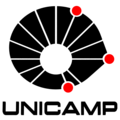
# Universidade Estadual de Campinas
---


### IA368/X - Ciência e Visualização de Dados em Saúde
##### E2: Entrega Final (Modelos de algoritimos de machine learning)


**Alunos**


1. Ana Carolina Furiozo Arantes
2. Ivan Paulino Pereira
3. Kleber Marcelo da Silva Rezende
4. Marilia Santoro Cardoso

# **Introdução**

Este notebook utiliza algoritimos de Machine Learn para tentar identificar os fatores associados a morte por a Covid em comparação com mortes decorridas de outras causas.

Neste trabalho foram utilizados dados anonimizados de pacientes com Covid do estado do Ceará, que foram dispobibilizados publicamente pela[IntegraSUS/CE](https://github.com/integrasus/api-covid-ce).

Este dataset possui 1.873.583 de registros de pacientes do estádo do Ceará acompanhados com sintomas de Covid. O dataset possui 43 features (colunas), sendo algumas relavantes para este trabalho, como por exemplo a relação de comorbidades do paciente. Apesar de possuir muitos registros o dataset apresenta aproximadamente 97% de informações faltantes em relação as comorbidades e outros fatores de risco. Mais informações sobre essa dataset podem ser obitidas no [notebook de análise exploratória](https://github.com/softip/projeto_IA368X/blob/main/notebooks/E2_An%C3%A1lise_Explorat%C3%B3ria.ipynb).

Além dos dados do IntegraSUS/CE foram utilizados dados demografícos dos municípios onde os pacientes residem, esses dados foram obtidos do [portal do IBGE](https://www.ibge.gov.br/cidades-e-estados/ce.html). Esse dataset possui informações demográficas, como área do munícipio, população, renda, número de matricula e ìndice de desenvolvimento Humano Municipal - IDHM. Esse dataset foi utilizado para verificar se fatores sociais podem estar associado as mortes por Covid. 

Os datasets utilizado neste notebook são resultados as etapas de pré-processamento: limpeza de dados e transformação de dados. Para comprender melhor como os dados foram tratados é possível acessar os notebooks de preparação dos dados [Dataset1:RandomForest](https://github.com/softip/projeto_IA368X/blob/main/notebooks/Tratamentode_Dados_para_ML_random_florest.ipynb) e [Dataset2:Regression COX](https://github.com/softip/projeto_IA368X/blob/main/notebooks/Tratamentode_Dados_para_ML_Cox.ipynb)

Este trabalho apresenta a aplicação de dois algoritimos de machine learn. O primeiro utiliza o algoritimo de florestas aleatórias (Random Forest) para classificar as mortes em decorrencia de Covid ou por outras causas. O Random Forest, assim com outros algoritmos baseados em árvores de decisão possibilitam o estudo de como a classificação foi realizada, de forma a comprender quais características ou fatores contribuem mais para o evento, nesse caso a morte por Covid.

O Segundo algoritimo utilizado é o Regression COX, que faz parte da família de algoritimos de análise de sobrevivência. O modelo criado tem o objetivo de prever quais características (fatores) contribuem para a morte devido a Covid.



# **Modelo 1: Random Forest Classifier**

O Random Forest é um algoritmo de aprendizagem de máquina utilizado para realizar classificação e regressão. O algoritmo criar diversas árvores de decisão, escolhendo aleatóriamente as features que serão utilizados em cada árvores. O resultado da classificação é realizado considerando os votos de cada árvore da floresta na predição realizada.

Esse algoritimo apresenta bons resultados, mesmo sem ajuste de hiperparâmetros. Além disso, é possivel visualizar como a classificação foi realizada e quais features são mais importantes para a classificação.

Neste seção vamos tentar prever se a óbito do paciente foi devido a Covid ou se teve outras causas. Ao final vamos verificar quais caracteristicas estão mais associadas as mortes por Covid.



In [3]:
#Importação de bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Importção das bibliotecas para machine learn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

In [4]:
#Importa o dataset já preparado para o treinamento
dfRandom = pd. read_csv("https://raw.githubusercontent.com/softip/projeto_IA368X/main/data/processed/DataSetCovidIBGE_RandomFlorest.csv")
dfRandom.head(3)

,sexoPaciente,idadePaciente,racaCorPaciente,Asma,Cardiovascular,Diabetes,Hematologia,Imunodeficiencia,Neurologia,Obesidade,Pneumopatia,Puerpera,Renal,SindromeDown,area_territorial_km2,populacao_estimada_2020,densidade_demografica_hab_km2_2010,escolarizacao6a14 anos_2010,IDHM_2010,mortalidade_infantil_2019,PIB_per_capita_2018,obitoConfirmado
0,1,68.0,3,0,1,0,0,0,0,1,0,0,0,0,312.353,2686612,7786.44,96.1,0.754,11.67,25356.73,1.0
1,1,72.0,0,0,1,1,0,0,0,0,0,0,0,0,312.353,2686612,7786.44,96.1,0.754,11.67,25356.73,1.0
2,1,64.0,0,0,1,0,0,0,0,0,0,0,0,0,312.353,2686612,7786.44,96.1,0.754,11.67,25356.73,1.0


In [5]:
#Cria a classe para realizar o treinamento e a predição
class MyModelML():

  N_ESTIMATOR = 200
  RANDOM_STATE = 42
  TEST_SIZE = 0.2

  def __init__(self, df, col_y):  
    X, Y = self.separar_xy(df, col_y)
    X = self.tratamento(X)
    self.X_train, self.X_test, self.Y_train, self.Y_test = train_test_split(X, Y, 
              test_size=self.TEST_SIZE, random_state=self.RANDOM_STATE)
    self.Y_pred = self.train_rbf()
    
  def separar_xy(self, df, col_y):
    X = df.drop(columns=[col_y], axis=1) #remove a coluna Y
    Y = df.loc[:, col_y]                 #seleciona apenas a coluna Y
    return X, Y

  def tratamento(self, X):
    X  = self.categorizar(X)        #faz a categorização, colunas com 0 e 1
    X = self.normalizar(X)          #faz a normalização converte para 0 e 1
    return X

  # faz a discretização das variaveis categorias
  def categorizar(self, df):
    return pd.get_dummies(df)

  #faz a normalização dos dados para escala de 0 e 1
  def normalizar(self, df):
    scaler = MinMaxScaler() 
    matriz_01 = scaler.fit_transform(df)
    #transforma a resultado novamente em DataFrame
    return pd.DataFrame(matriz_01, columns = df.columns)

  #cria o modelo de machine learning: floresta aleatórias
  def train_rbf(self):
    self.rf = RandomForestClassifier(n_estimators=self.N_ESTIMATOR, 
                                     random_state= self.RANDOM_STATE )
    self.rf.fit(self.X_train, self.Y_train) #faz o treinamento
    self.Y_pred = self.rf.predict(self.X_test) #faz as predições
    return self.Y_pred

  def calcular_erro_medio(self):
    return mean_squared_error(self.Y_test, self.Y_pred)

  def get_matriz_confusao(self):
    return  confusion_matrix(self.Y_test, self.Y_pred)    
    
  def get_metrics(self):
    vn, fp, fn, vp = confusion_matrix(self.Y_test, self.Y_pred).ravel()
    acuracia = (vp+vn)/(vp+vn+fp+fn)
    precisao = vp / (vp+fp)
    revocacao = vp / (vp+fn)
    sensibilidade = vp / (vp+fn)
    especificidade = vn / (fp + vn)
    f1_score = ((2 * precisao) + revocacao) / (precisao + revocacao)
    return acuracia, precisao, revocacao, f1_score, sensibilidade, especificidade

  def print_metrics(self):    
    print(classification_report(self.Y_test, self.Y_pred, target_names=["Óbito", "Curado"]))

  def get_feature_importances(self):
    return pd.Series(self.rf.feature_importances_, index=self.X_test.columns.tolist()
    ).sort_values(ascending=False).head(10)
    
  def get_predicts(self):
    return self.Y_pred

In [6]:
#Chama a classe MyModel que faz o treinamento do modelo
#São passados como parâmentros o dataset com as features e o nome da coluna alvo
myModel = MyModelML(dfRandom, 'obitoConfirmado')

In [7]:
#Imprime as métricas do modelo
acuracia, precisao, revocacao, f1_score, sensibilidade, especificidade = myModel.get_metrics() 
print("Acurácia: {:.1f}".format(acuracia * 100))
print("Sensibilidade: {:.1f}".format(sensibilidade * 100))
print("Especificidade: {:.1f}".format(especificidade * 100))

Acurácia: 87.4
Sensibilidade: 96.2
Especificidade: 12.3


In [9]:
#imprime a matriz de confusão
myModel.get_matriz_confusao()

array([[  36,  256],
       [  94, 2397]])

Text(0.5, 1.0, 'Fatores com maior associação a mortes por Covid')

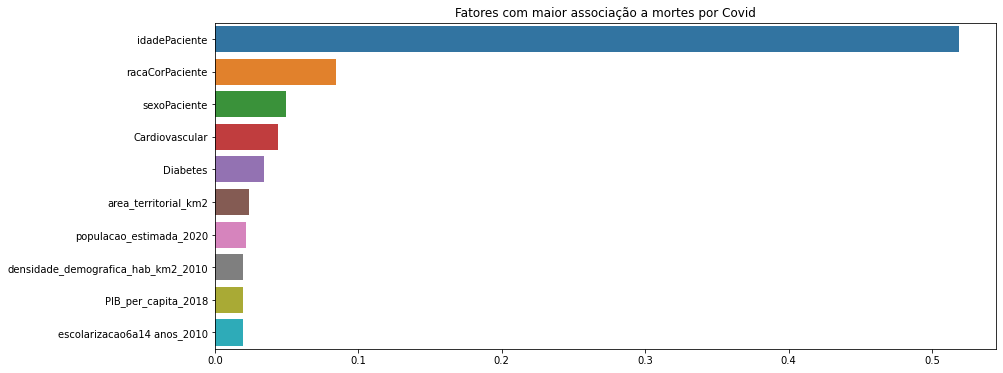

In [11]:
#imprime os principais fatores associados as mortes por Covid
plt.figure(figsize=(14,6))
df = myModel.get_feature_importances()
sns.barplot(x=df.values, y=df.index).set_title("Fatores com maior associação a mortes por Covid")

## **Conclusões**

O modelo de floresta aletória apresentou acurácia de 87.4% e sensibilidade para detectar as mortes causadas por Covid de 96.2%. No entanto, o modelo apresentou uma especificidade muito baixa, ou seja, ele possui baixa capacidade de prever as mortes causadas por outras causas. Esse problema pode ter ocorrido devido a quantidade menor e desproporcional de registros de mortes devido outras causas.

O modelo apresentou que os fatores mais associados a morte devido a Covid são:
1. A idade do paciente;
2. Raça/Cor do paciente;
3. O sexo;
4. Doenças cardiovasculares
5. Diabetes;

Os fatores demográfico em relação aos municípios onde os pacientes residiam não tiveram grande associação com as mortes devido a Covid. No entanto, alguns fatores foram considerados mais importantes do que algumas comorbidades, tais como a área territorial e a população estimada.



# **Modelo 2: Regression COX**

A análise de sobrevivência  é um conjunto de abordagens estatísticas usadas para descobrir o tempo que um evento de interesse (geralmente chamado de morte) leva para ocorrer leva. Essa abordagem é frequentemente utilizada em dados de saúde, para prever fatores associados a morte, tratamento com maior probabilidade de sobrevivência, etc.

Neste modelo vamos comparar os fatores associados a morte por Covid .

In [ ]:
#importa bibliotecas básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#instala e importa o pacote lifelines
!pip install lifelines
from lifelines import CoxPHFitter

In [21]:
#Abre o dataset preparado para o treinamento utilizando regression cox
df = pd. read_csv("https://raw.githubusercontent.com/softip/projeto_IA368X/main/data/processed/DatasetCovidTratadoCox.csv")
df.head(2)

,sexo,idadePaciente,racaCor,Asma,Cardiovascular,Diabetes,Hematologia,Imunodeficiencia,Neurologia,Obesidade,Pneumopatia,Puerpera,Renal,SindromeDown,tempo_vida,area_territorial_km2,populacao_estimada_2020,densidade_demografica_hab_km2_2010,escolarizacao6a14 anos_2010,IDHM_2010,mortalidade_infantil_2019,PIB_per_capita_2018,target
0,0.0,83.0,0.0,0,1,0,0,0,1,0,0,0,0,0,479.0,312.353,2686612,7786.44,96.1,0.754,11.67,25356.73,1.0
1,1.0,39.0,1.0,0,0,0,0,0,0,0,0,0,0,0,468.0,312.353,2686612,7786.44,96.1,0.754,11.67,25356.73,0.0


In [22]:
# Faz o treinamento do modelo
# No treinamento todas as features são utilizadas, 
# No entanto é necessário passar o tempo de sobrevivência (tempo_vida) e a ocorrência do evento (target)
# O tempo de vida foi criado subtraindo a data do óbito da data de manifestação dos sintomas
# Nos casos onde o óbito não ocorreu foi utilizada no lugar da data do óbito a data de extração do dataset do portal IntegraSUS
# A coluna target informa se o paciente se recuperou 0 ou se veio a óbito 1

cph = CoxPHFitter()
cph.fit(df,"tempo_vida",event_col="target")
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 19834 total observations, 8071 right-censored observations>
             duration col = 'tempo_vida'
                event col = 'target'
      baseline estimation = breslow
   number of observations = 19834
number of events observed = 11763
   partial log-likelihood = -109282.75
         time fit was run = 2021-06-24 14:23:45 UTC

---
                                     coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                  
sexo                                 0.08       1.08       0.02             0.04             0.12                 1.04                 1.12
idadePaciente                        0.03       1.03       0.00             0.03             0.03                 1.03                 1.03
racaCor                             -0.02       0.98       0.02            -0.06             0.01                 0.94                 1.01
Asma                                 0.02       1.02       0.08            -0.13             0.17                 0.88                 1.19
Cardiovascular                      -0.02       0.98       0.02            -0.06             0.02                 0.94                 1.02
Diabetes                             0.06       1.06       0.02             0.02             0.10                 1.02                 1.11
Hematologia                         -0.05       0.95       0.12            -0.29             0.18                 0.75                 1.20
Imunodeficiencia                     0.03       1.03       0.06            -0.09             0.14                 0.91                 1.16
Neurologia                           0.18       1.20       0.05             0.09             0.28                 1.09                 1.32
Obesidade                            0.47       1.60       0.04             0.40             0.55                 1.49                 1.73
Pneumopatia                          0.04       1.04       0.05            -0.06             0.15                 0.94                 1.16
Puerpera                            -0.52       0.59       0.20            -0.91            -0.13                 0.40                 0.88
Renal                                0.19       1.21       0.04             0.10             0.27                 1.11                 1.32
SindromeDown                         0.13       1.14       0.16            -0.18             0.44                 0.83                 1.55
area_territorial_km2                -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
populacao_estimada_2020              0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
densidade_demografica_hab_km2_2010  -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
escolarizacao6a14 anos_2010         -0.08       0.93       0.01            -0.10            -0.06                 0.91                 0.94
IDHM_2010                           -1.27       0.28       0.39            -2.03            -0.52                 0.13                 0.60
mortalidade_infantil_2019           -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
PIB_per_capita_2018                  0.00       1.00       0.00             0.00             0.00                 1.00                 1.00

                                       z      p   -log2(p)
covariate                                                 
sexo                                4.25 <0.005      15.54
idadePaciente                      46.65 <0.005        inf
racaCor                            -1.23   0.22       2.19
Asma                                0.26   0.80       0.33
Cardiovascular                     -1.14   0.26    

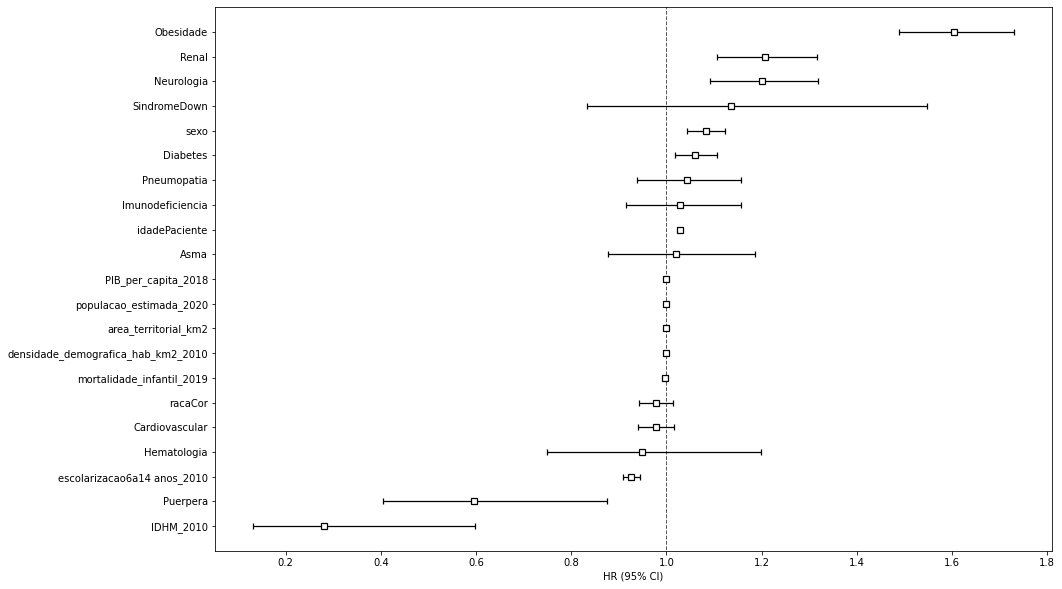

In [23]:
#imprime a razão de risco (hazard ratio (HR))
#HR = 1: Sem efeito
#HR < 1: Redução do risco
#HR > 1: Aumento do risco
#No Gráfico os dados estão sendo plotados em log
plt.figure(figsize=(15,10))
cph.plot(hazard_ratios=True)

## **Conclusão**

O modelo de Regressão COX deve ser analisado avaliando o Hazard Ratio (exp(coef)). Resumidamente temos:
* HR = 1: Sem efeito
* HR < 1: Redução do risco de morte
* HR > 1: Aumento do risco de morte

Pelo diagrama apresentado e analisando o HR e o p-value < 0,05, pode ser concluir que:
* A obesidade aumenta em 60% as chances de morte.
* Doenças neurológicas aumentam em 20% as chances de morte
* Doenças renais aumentam 21% as chances de morte
* IDHM - Índice de Desenvolvimento Humano Municipal aumenta em 82% as chances de sobrevivência
* Escolarização aumenta e 5% as chances de sobrevivência
